# **Initial Data Exploration**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
df = pd.read_csv("/content/Manila_City_Only_List.csv")

# 2. Missing Value Analysis
# We need to count both standard NaNs and text "na"
missing_counts = {}
for col in df.columns:
    nan_count = df[col].isnull().sum()
    # Check for "na" string if column is text
    if df[col].dtype == 'object':
        na_str_count = df[col].astype(str).str.strip().str.lower().eq('na').sum()
    else:
        na_str_count = 0
    missing_counts[col] = nan_count + na_str_count

df.head(5)


,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Longtitude,Latitude,Post URL
0,NaN,59,male,1/14/2020,12:48 PM,12/14/2019,"Malate, Manila",NaN,NaN,https://www.facebook.com/share/p/1Fp5H7uddW/
1,NaN,41,Male,01/24/2020,5:12 PM,01/16/2021,"Sampaloc, Manila",NaN,NaN,https://www.facebook.com/share/p/1CwZW3pbpf/
2,NaN,43,Male,2/9/2020,7:03 PM,NaN,"Tondo, Manila",NaN,NaN,https://www.facebook.com/share/p/1CoiXoTEjb/
3,NaN,14,Male,2/15/2020,12:19 PM,na,"Binondo, Manila",NaN,NaN,https://www.facebook.com/share/p/17Umn23xj9/
4,NaN,16,male,03/23/2020,12:25,03/11/2025,"Paco,. Manila",NaN,NaN,https://www.facebook.com/share/p/1BhMzYvEJN/


Total Dataset Empty: 35.31%
Missing Counts per Column: {'Person ID': np.int64(113), 'AGE': np.int64(0), 'GENDER': np.int64(0), 'Date Reported Missing': np.int64(0), 'Time Reported Missing': np.int64(5), 'Date Last Seen': np.int64(54), 'Location Last Seen': np.int64(0), 'Longtitude': np.int64(113), 'Latitude': np.int64(113), 'Post URL': np.int64(1)}


/tmp/ipython-input-1183053842.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r')


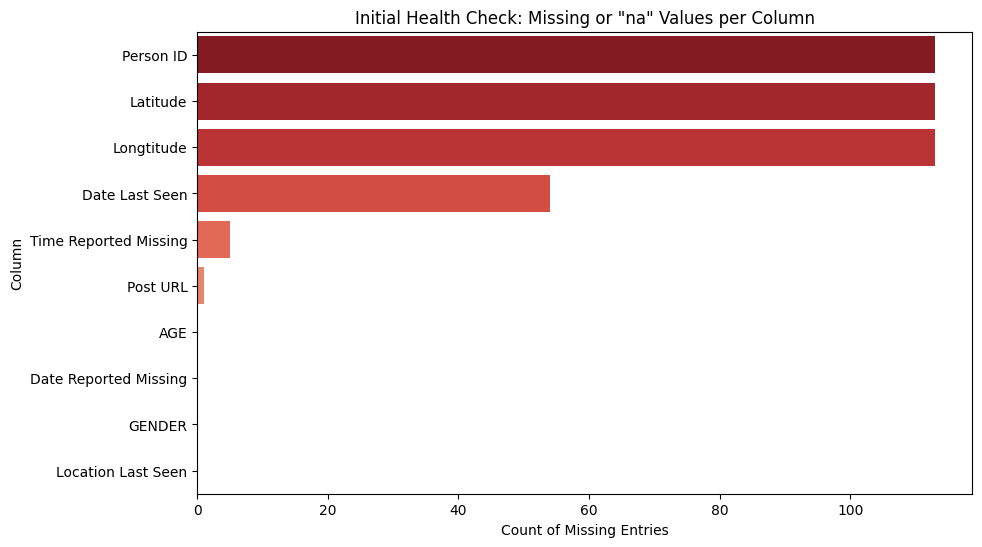

In [2]:
# Calculate total percentage empty
total_cells = df.size
total_missing = sum(missing_counts.values())
percent_empty = (total_missing / total_cells) * 100

print(f"Total Dataset Empty: {percent_empty:.2f}%")
print("Missing Counts per Column:", missing_counts)

# 3. Visualization
missing_df = pd.DataFrame(list(missing_counts.items()), columns=['Column', 'Missing Count'])
missing_df = missing_df.sort_values(by='Missing Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Missing Count', y='Column', palette='Reds_r')
plt.title('Initial Health Check: Missing or "na" Values per Column')
plt.xlabel('Count of Missing Entries')
plt.show()

## **Data Preprocessing**

In [3]:
# 1. Drop Irrelevant Columns
df_clean = df.drop(columns=['Latitude', 'Longtitude'])

In [4]:
# 2. Standardize Demographics
# Clean Gender (remove spaces, capitalize)
df_clean['GENDER'] = df_clean['GENDER'].str.strip().str.capitalize()

In [5]:
# 3. Parse Dates & Times
# Convert Date columns
df_clean['Date Reported Missing'] = pd.to_datetime(df_clean['Date Reported Missing'], errors='coerce')

In [6]:
# Handle 'na' in Date Last Seen before converting
df_clean['Date Last Seen'] = df_clean['Date Last Seen'].replace('na', pd.NA)
df_clean['Date Last Seen'] = pd.to_datetime(df_clean['Date Last Seen'], errors='coerce')

# Clean Time: Handle 'na' and convert mixed formats (12h/24h)
df_clean['Time Reported Missing'] = df_clean['Time Reported Missing'].replace('na', pd.NA)
# The datetime converter infers the correct format automatically
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')

/tmp/ipython-input-1347800615.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


In [7]:
df_clean.head(5)

,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj
0,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-10 12:48:00
1,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-10 17:12:00
2,NaN,43,Male,2020-02-09,7:03 PM,NaT,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-10 19:03:00
3,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-10 12:19:00
4,NaN,16,Male,2020-03-23,12:25,2025-03-11,"Paco,. Manila",https://www.facebook.com/share/p/1BhMzYvEJN/,2025-12-10 12:25:00


In [8]:
df_clean = df_clean.sort_values(by='Date Reported Missing', ascending=True)

## **Age Binning**

In [9]:
def smart_bin_age(val):
    s_val = str(val).lower().strip()
    if s_val == 'adult': return 'Adult'
    elif s_val in ['senior', 'adult older']: return 'Old'
    elif s_val == 'teen': return 'Teen'
    elif s_val == 'young teen': return 'Young Teen'
    elif s_val == 'young adult': return 'Young Adult'
    elif s_val == 'child': return 'Child'

    try:
        age_num = float(val)
        if pd.isna(age_num): return "Unknown"
        if age_num < 13: return "Child"
        elif 13 <= age_num <= 14: return "Young Teen"
        elif 15 <= age_num <= 17: return "Teen"
        elif 18 <= age_num <= 24: return "Young Adult"
        elif 25 <= age_num <= 59: return "Adult"
        else: return "Old"
    except:
        return "Unknown"

/tmp/ipython-input-4055080421.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')


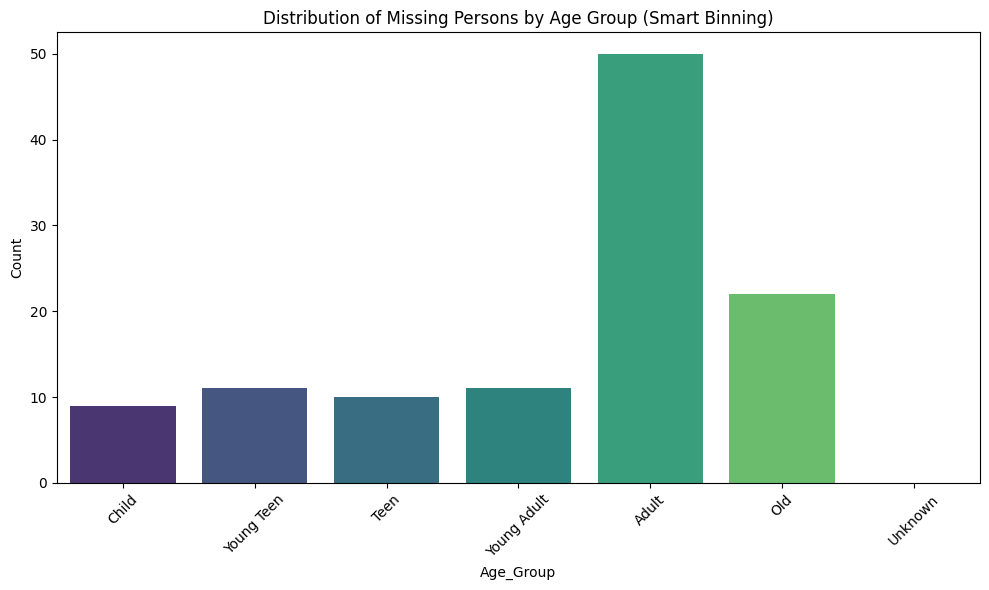

In [10]:
# Apply Logic
df_clean['Age_Group'] = df_clean['AGE'].apply(smart_bin_age)

# Plotting
plt.figure(figsize=(10, 6))
order = ["Child", "Young Teen", "Teen", "Young Adult", "Adult", "Old", "Unknown"]
sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')
plt.title('Distribution of Missing Persons by Age Group (Smart Binning)')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## **City - Baranggay Segregation**

In [11]:
mm_cities_list = [
    "manila", "quezon", "caloocan", "las piñas", "las pinas", "makati",
    "malabon", "mandaluyong", "marikina", "muntinlupa", "navotas",
    "parañaque", "paranaque", "pasay", "pasig", "pateros", "san juan",
    "taguig", "valenzuela", "antipolo"
]

def parse_location(loc):
    if pd.isna(loc) or str(loc).lower() == 'na': return "Unknown"

    loc_str = str(loc)
    # Cleanup: normalize case and remove 'city' for matching
    loc_clean = loc_str.lower().replace("city", "").replace(".", "")

    # Match against known list
    found_city = "Other/Unknown"
    for city in mm_cities_list:
        if city in loc_clean:
            # Handle spelling variations
            if city == "las pinas": found_city = "Las Piñas"
            elif city == "paranaque": found_city = "Parañaque"
            else: found_city = city.title()
            break

    return found_city

df_clean['City_Cleaned'] = df_clean['Location Last Seen'].apply(parse_location)

# 3. Clean Date & Time
df_clean['Date Reported Missing'] = pd.to_datetime(df['Date Reported Missing'], errors='coerce')
df_clean['Year'] = df_clean['Date Reported Missing'].dt.year

df_clean['Time Reported Missing'] = df_clean['Time Reported Missing'].replace('na', pd.NA)
df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')
df_clean['Hour_Missing'] = df_clean['Time_Obj'].dt.hour

df_clean.to_csv("DMResearch - Missing People.csv", index=False)

/tmp/ipython-input-2124726120.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean['Time_Obj'] = pd.to_datetime(df_clean['Time Reported Missing'], errors='coerce')


In [12]:
df_clean.head(5)

,Person ID,AGE,GENDER,Date Reported Missing,Time Reported Missing,Date Last Seen,Location Last Seen,Post URL,Time_Obj,Age_Group,City_Cleaned,Year,Hour_Missing
0,NaN,59,Male,2020-01-14,12:48 PM,2019-12-14,"Malate, Manila",https://www.facebook.com/share/p/1Fp5H7uddW/,2025-12-10 12:48:00,Adult,Manila,2020.0,12.0
1,NaN,41,Male,2020-01-24,5:12 PM,2021-01-16,"Sampaloc, Manila",https://www.facebook.com/share/p/1CwZW3pbpf/,2025-12-10 17:12:00,Adult,Manila,2020.0,17.0
2,NaN,43,Male,2020-02-09,7:03 PM,NaT,"Tondo, Manila",https://www.facebook.com/share/p/1CoiXoTEjb/,2025-12-10 19:03:00,Adult,Manila,2020.0,19.0
3,NaN,14,Male,2020-02-15,12:19 PM,NaT,"Binondo, Manila",https://www.facebook.com/share/p/17Umn23xj9/,2025-12-10 12:19:00,Young Teen,Manila,2020.0,12.0
14,NaN,13,Male,2020-03-11,1:02 PM,2019-12-15,"Tondo Church, Manila",https://www.facebook.com/groups/19006007444518...,2025-12-10 13:02:00,Young Teen,Manila,2020.0,13.0


## **Exploratory Data Analysis**

/tmp/ipython-input-3389320361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')


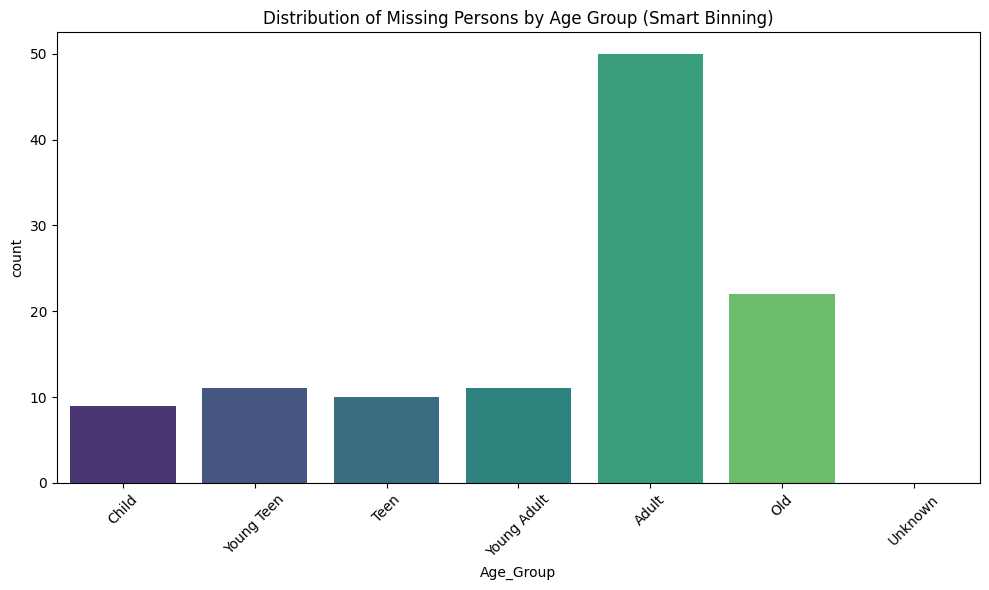

In [13]:
# Chart 1: Demographics (Smart Binning)
plt.figure(figsize=(10, 6))
order = ["Child", "Young Teen", "Teen", "Young Adult", "Adult", "Old", "Unknown"]
sns.countplot(data=df_clean, x='Age_Group', order=order, palette='viridis')
plt.title('Distribution of Missing Persons by Age Group (Smart Binning)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

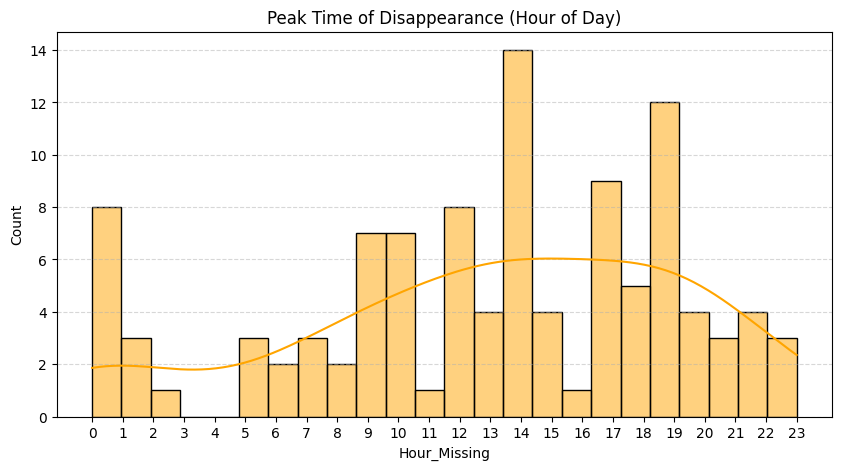

In [15]:
# 3. Temporal: Peak Time
plt.figure(figsize=(10, 5))
sns.histplot(data=df_clean, x='Hour_Missing', bins=24, kde=True, color='orange')
plt.title('Peak Time of Disappearance (Hour of Day)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

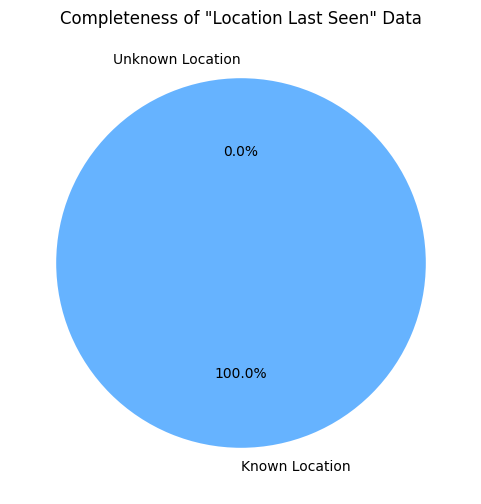

In [16]:
# 4. Data Completeness: Location Check
missing_loc_count = df_clean['Location Last Seen'].isnull().sum() + \
                    (df_clean['Location Last Seen'].astype(str).str.lower() == 'na').sum()
present_loc_count = len(df_clean) - missing_loc_count

plt.figure(figsize=(6, 6))
plt.pie([present_loc_count, missing_loc_count], labels=['Known Location', 'Unknown Location'],
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Completeness of "Location Last Seen" Data')
plt.show()

## **Rose Diagram**

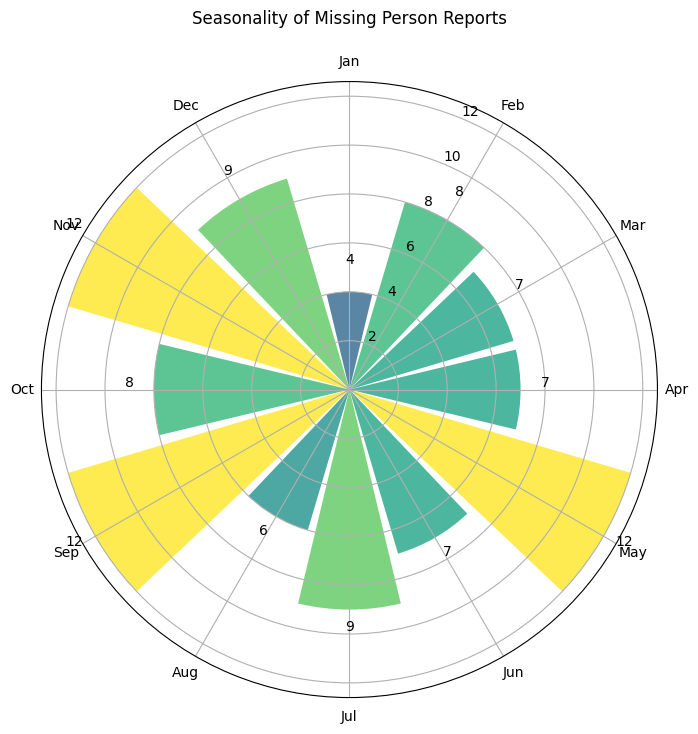

In [17]:
import numpy as np

# The 'Date Reported Missing' column in df_clean is already in datetime format from previous steps.
# We will use df_clean directly to ensure consistency.
df_dates = df_clean.dropna(subset=['Date Reported Missing']).copy()
df_dates['Month'] = df_dates['Date Reported Missing'].dt.month

# 2. Aggregation
# Count reports per month and ensure all 12 months are represented
monthly_counts = df_dates['Month'].value_counts().sort_index()
# Fill missing months with 0
for m in range(1, 13):
    if m not in monthly_counts:
        monthly_counts[m] = 0
monthly_counts = monthly_counts.sort_index()

# 3. Plotting the Rose Diagram
# Setup angles and bar width
theta = np.linspace(0.0, 2 * np.pi, 12, endpoint=False)
width = (2 * np.pi) / 12 * 0.9

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Configure: 0 degrees at Top (North), Clockwise direction
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Draw bars
bars = ax.bar(theta, monthly_counts.values, width=width, bottom=0.0, alpha=0.8,
              color=plt.cm.viridis(monthly_counts.values / max(monthly_counts.values)))

# Add labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticks(theta)
ax.set_xticklabels(month_labels)

# Add numeric counts
for bar, angle, count in zip(bars, theta, monthly_counts.values):
    ax.text(angle, bar.get_height() + 1, str(count), ha='center', va='bottom', fontsize=10)

plt.title("Seasonality of Missing Person Reports", y=1.08)
plt.show()

## **Time Series Chart**

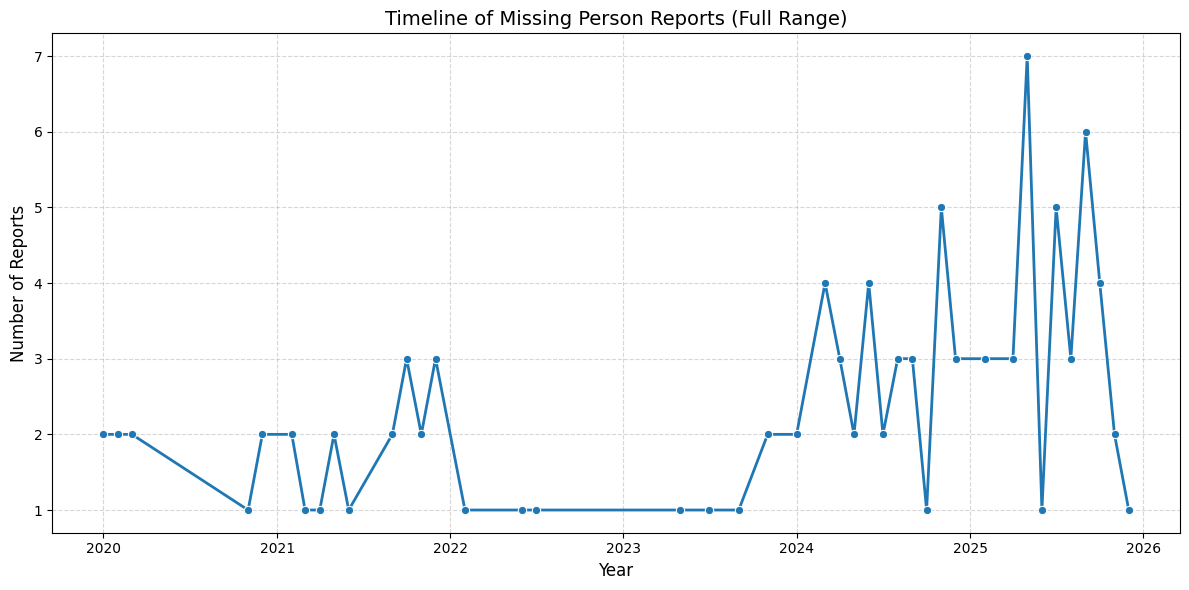

In [18]:
import matplotlib.dates as mdates

# Use all date entries from df_clean
df_ts = df_clean.copy()

# 2. Aggregation (Monthly)
# Group by Month to see the trend over time
monthly_counts = df_ts.groupby(df_ts['Date Reported Missing'].dt.to_period('M')).size()
monthly_counts.index = monthly_counts.index.to_timestamp()

# 3. Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o', color='#1f77b4', linewidth=2)

plt.title('Timeline of Missing Person Reports (Full Range)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reports', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Format X-Axis to show years clearly
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

## **Yearly Comparison (2020-2025)**
1.   Average Cases for each Month
2.   Gender
3.   Top Locations
4.   Age Group



/tmp/ipython-input-534750424.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str, dayfirst=False)
/tmp/ipython-input-534750424.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month_Name', data=data, order=month_order, ax=ax2, palette='Blues_d')
/tmp/ipython-input-534750424.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax3, palette='rocket')
/tmp/ipython-input-534750424.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign t

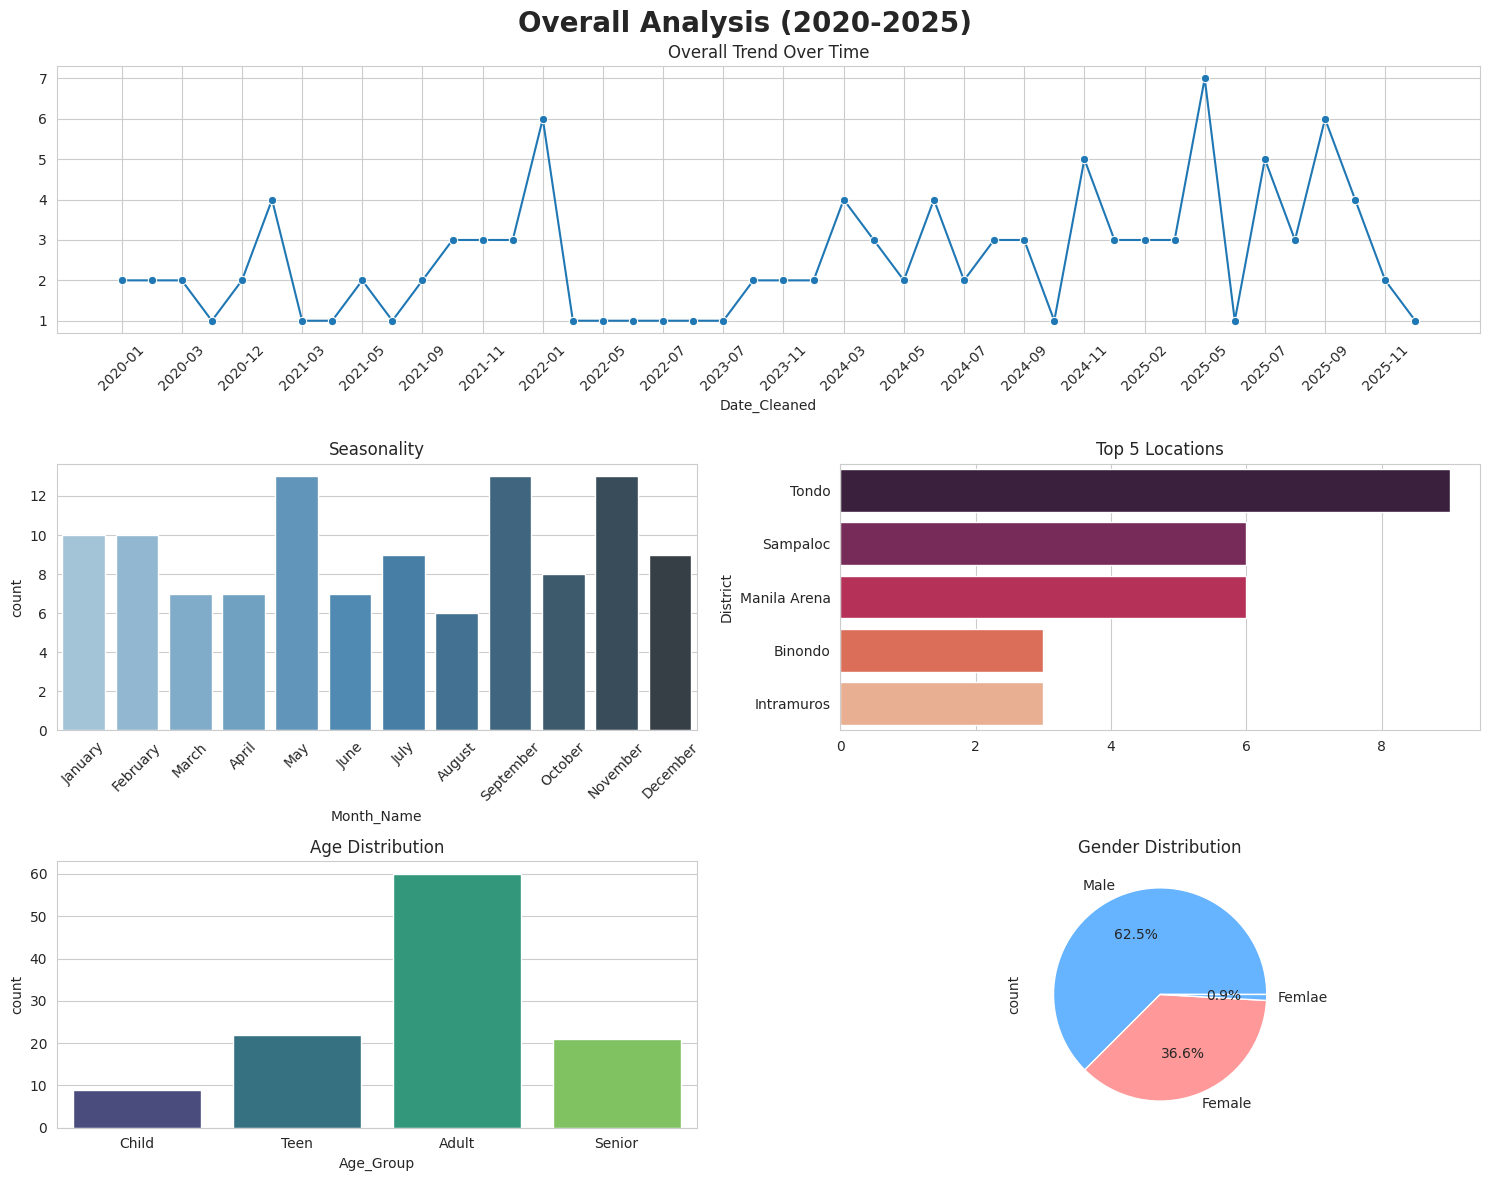

/tmp/ipython-input-534750424.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='Blues_d')
/tmp/ipython-input-534750424.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax2, palette='rocket')
/tmp/ipython-input-534750424.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax3, palette='viridis')


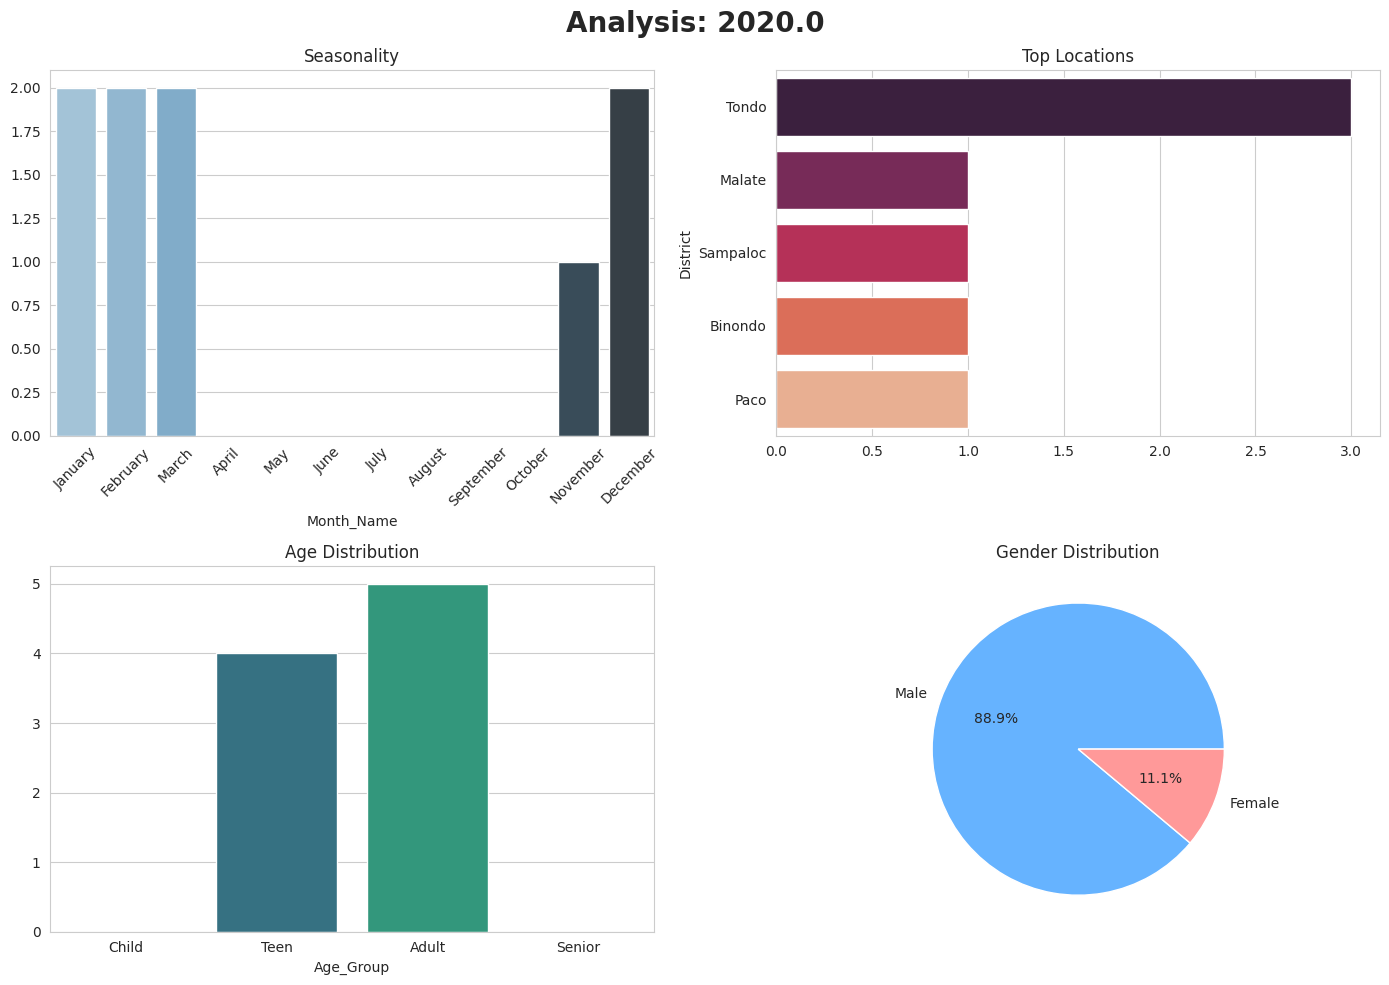

/tmp/ipython-input-534750424.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='Blues_d')
/tmp/ipython-input-534750424.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax2, palette='rocket')
/tmp/ipython-input-534750424.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax3, palette='viridis')


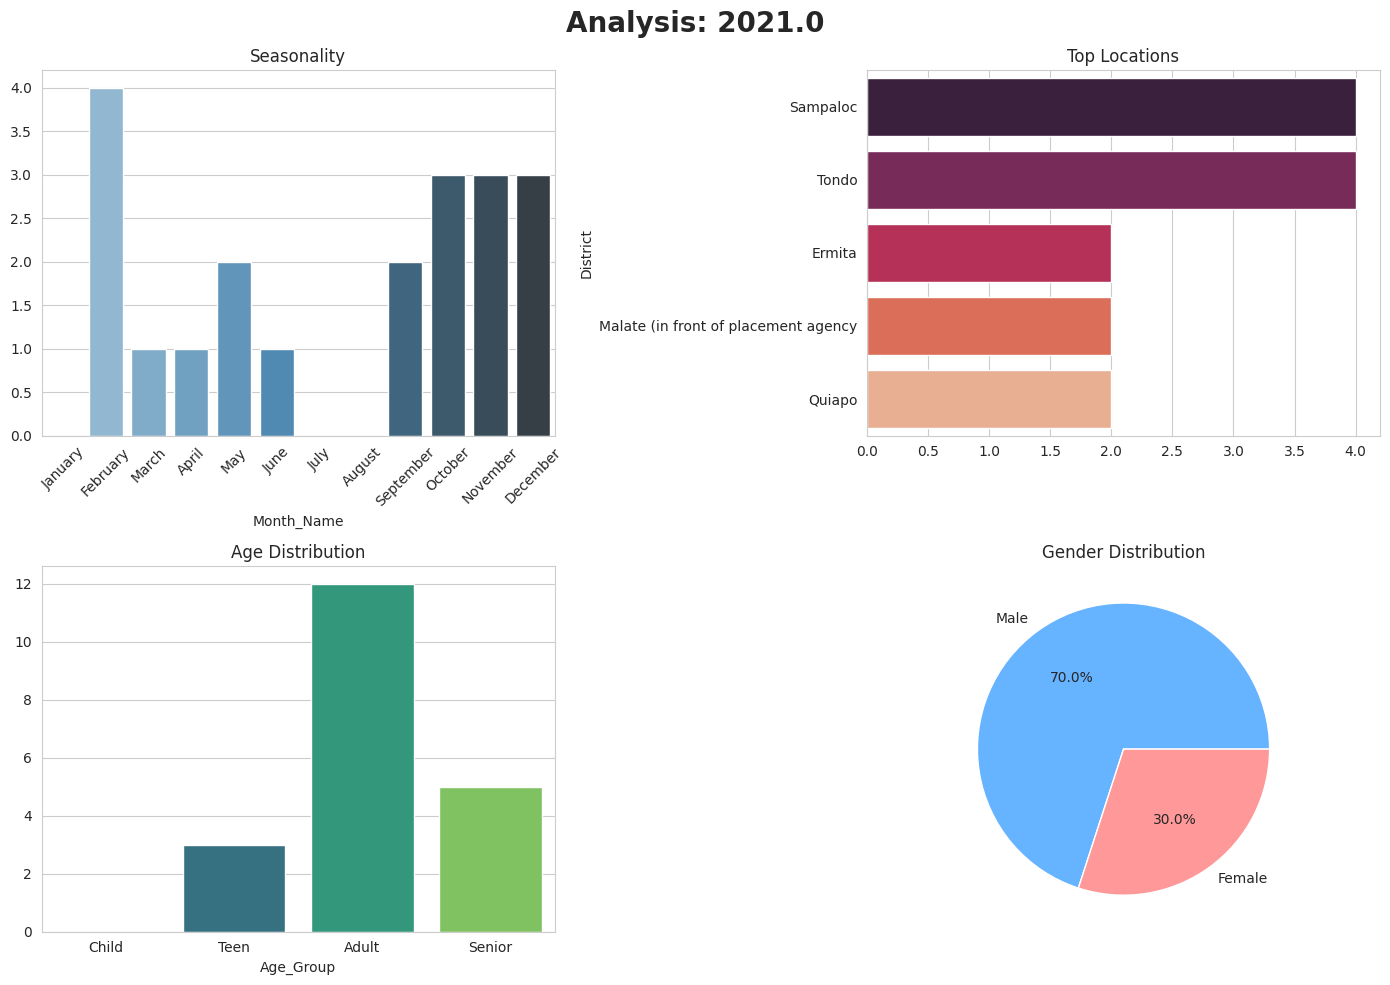

/tmp/ipython-input-534750424.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='Blues_d')
/tmp/ipython-input-534750424.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax2, palette='rocket')
/tmp/ipython-input-534750424.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax3, palette='viridis')


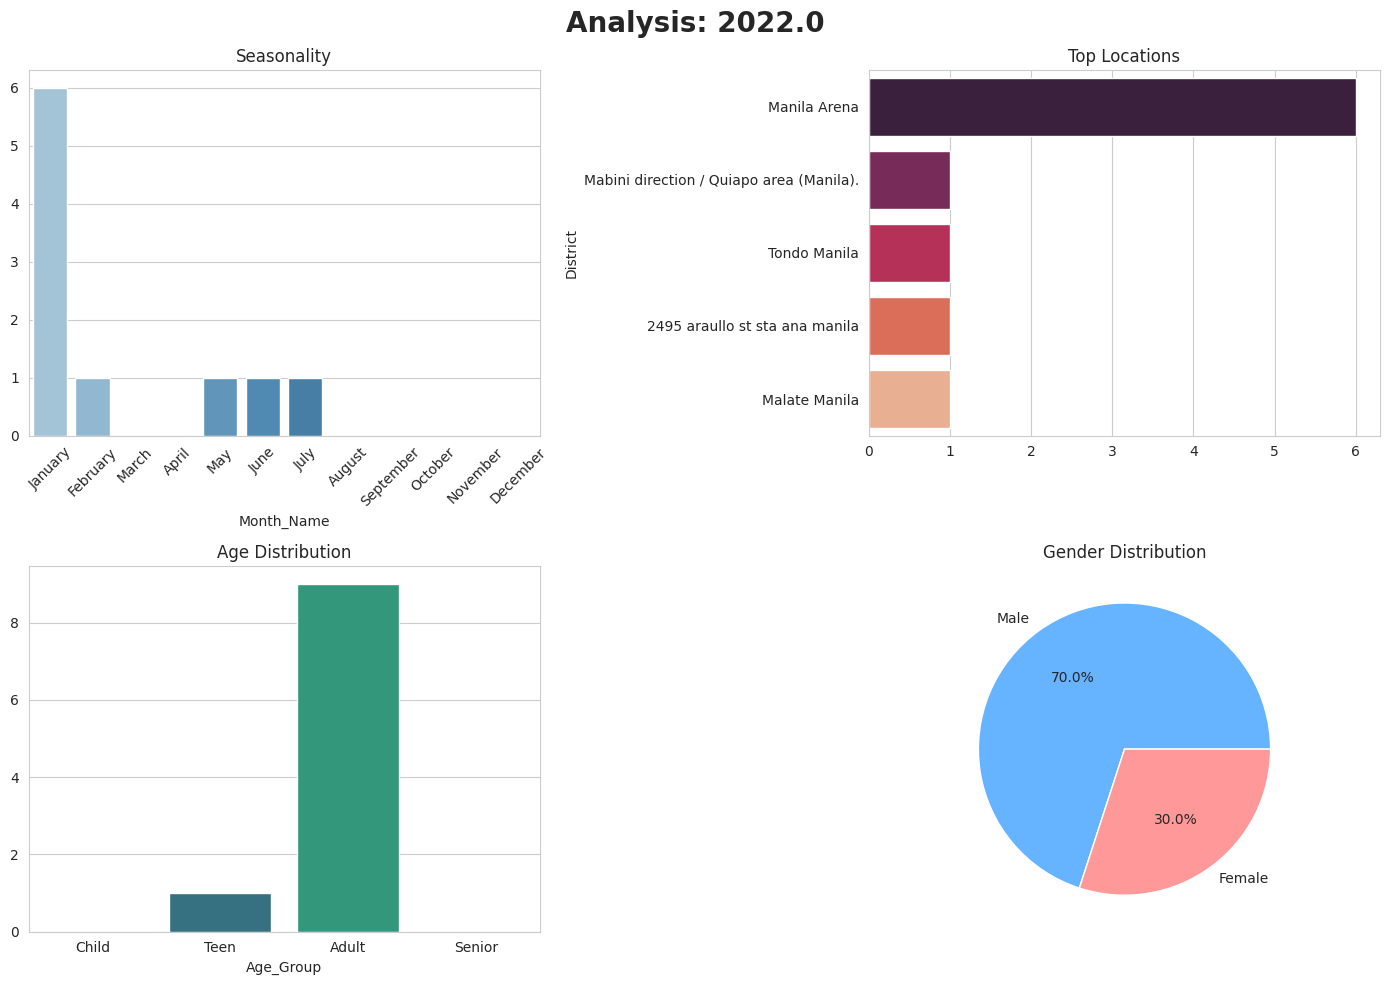

/tmp/ipython-input-534750424.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='Blues_d')
/tmp/ipython-input-534750424.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax2, palette='rocket')
/tmp/ipython-input-534750424.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax3, palette='viridis')


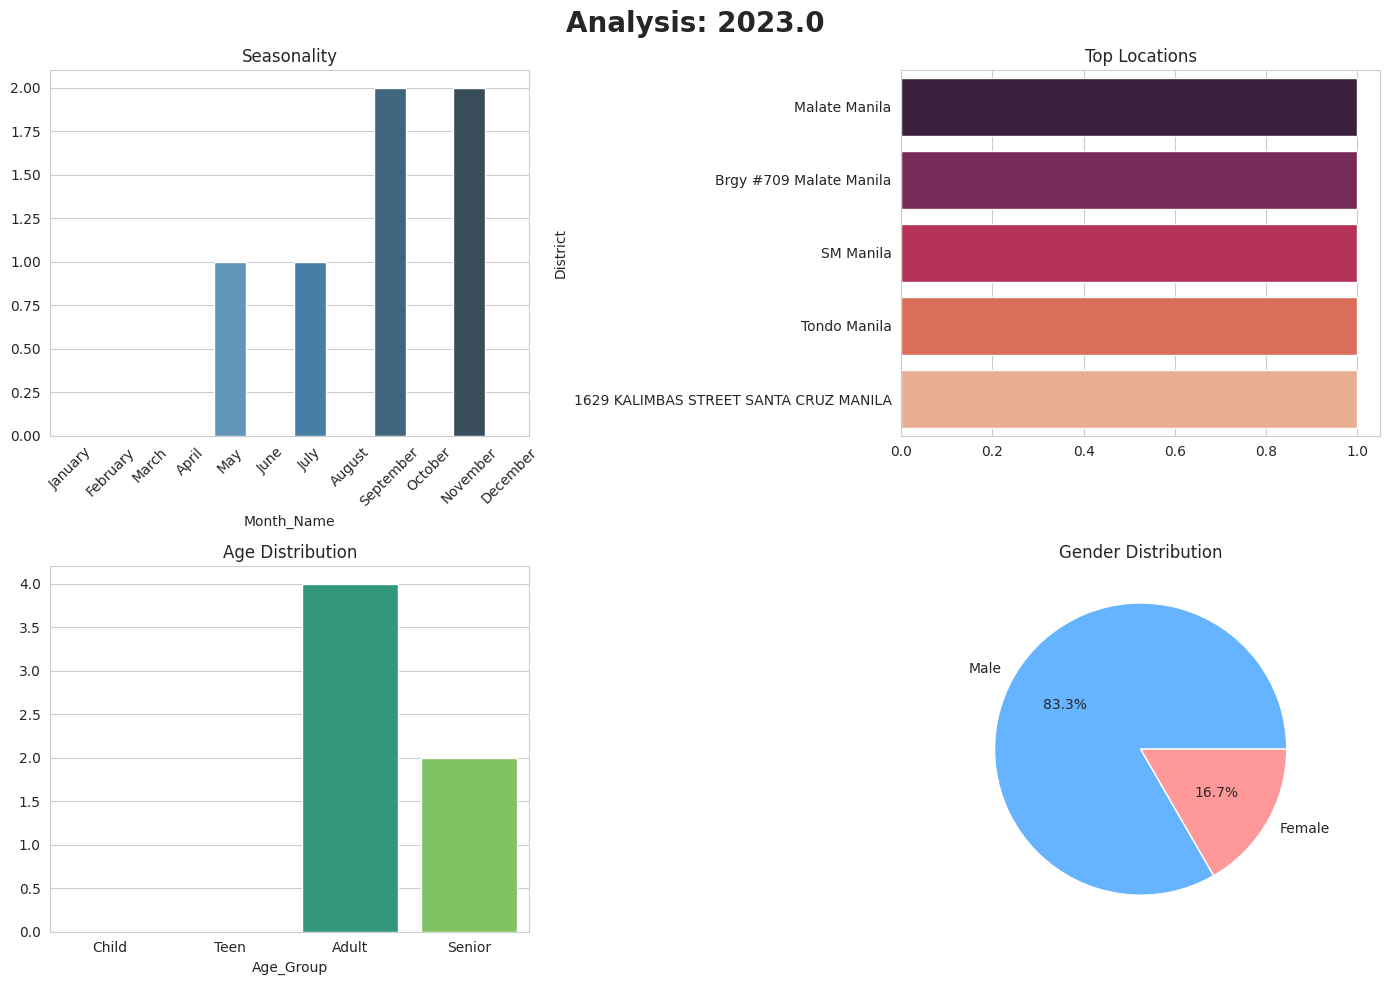

/tmp/ipython-input-534750424.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='Blues_d')
/tmp/ipython-input-534750424.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax2, palette='rocket')
/tmp/ipython-input-534750424.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax3, palette='viridis')


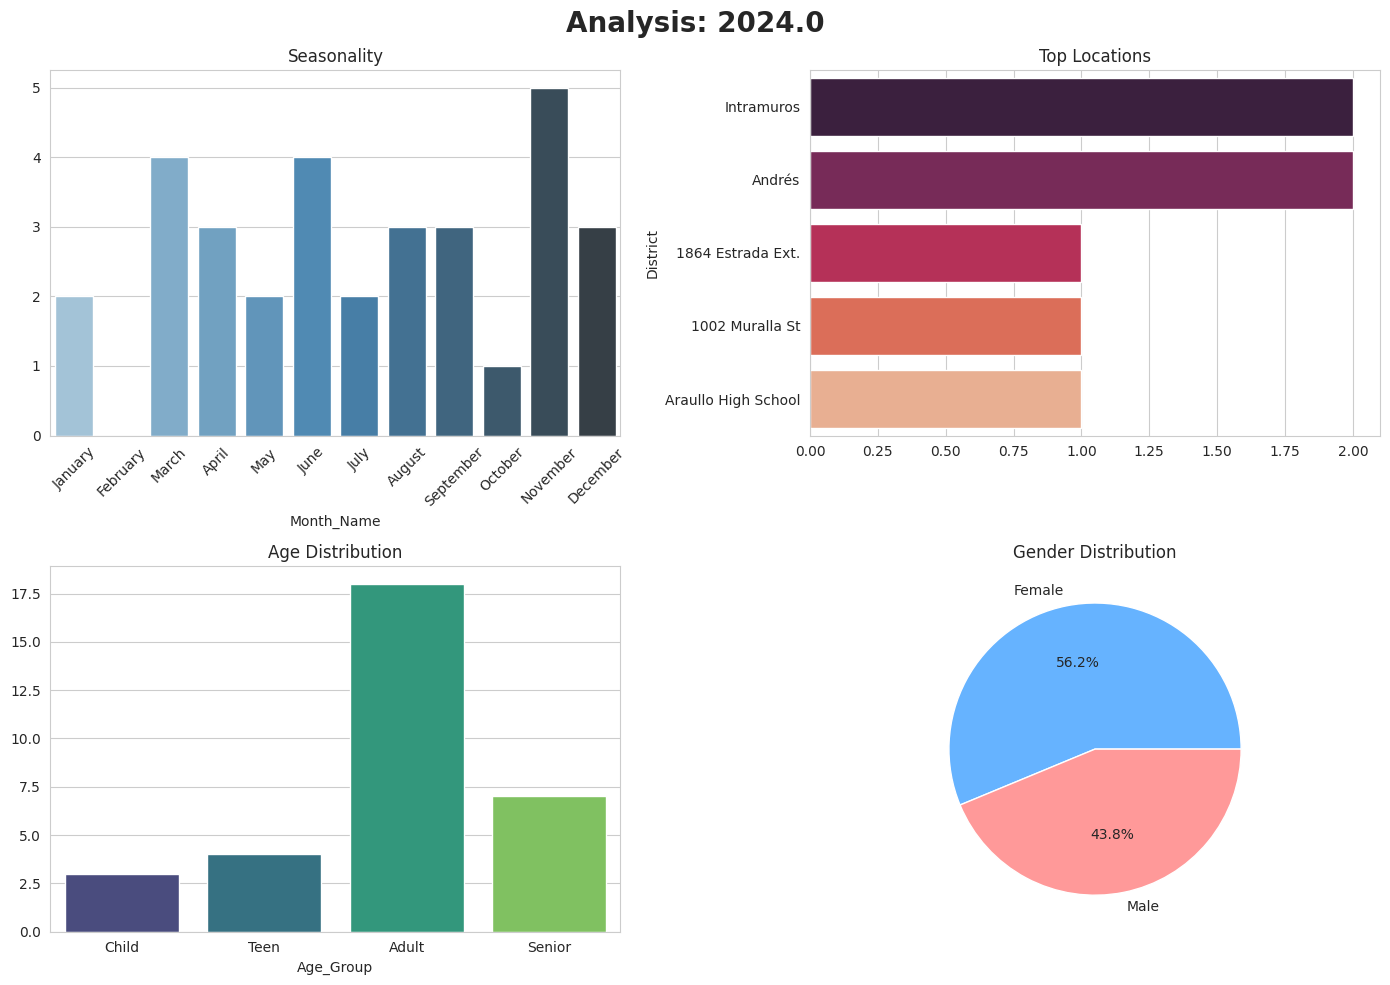

/tmp/ipython-input-534750424.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='Blues_d')
/tmp/ipython-input-534750424.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax2, palette='rocket')
/tmp/ipython-input-534750424.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax3, palette='viridis')


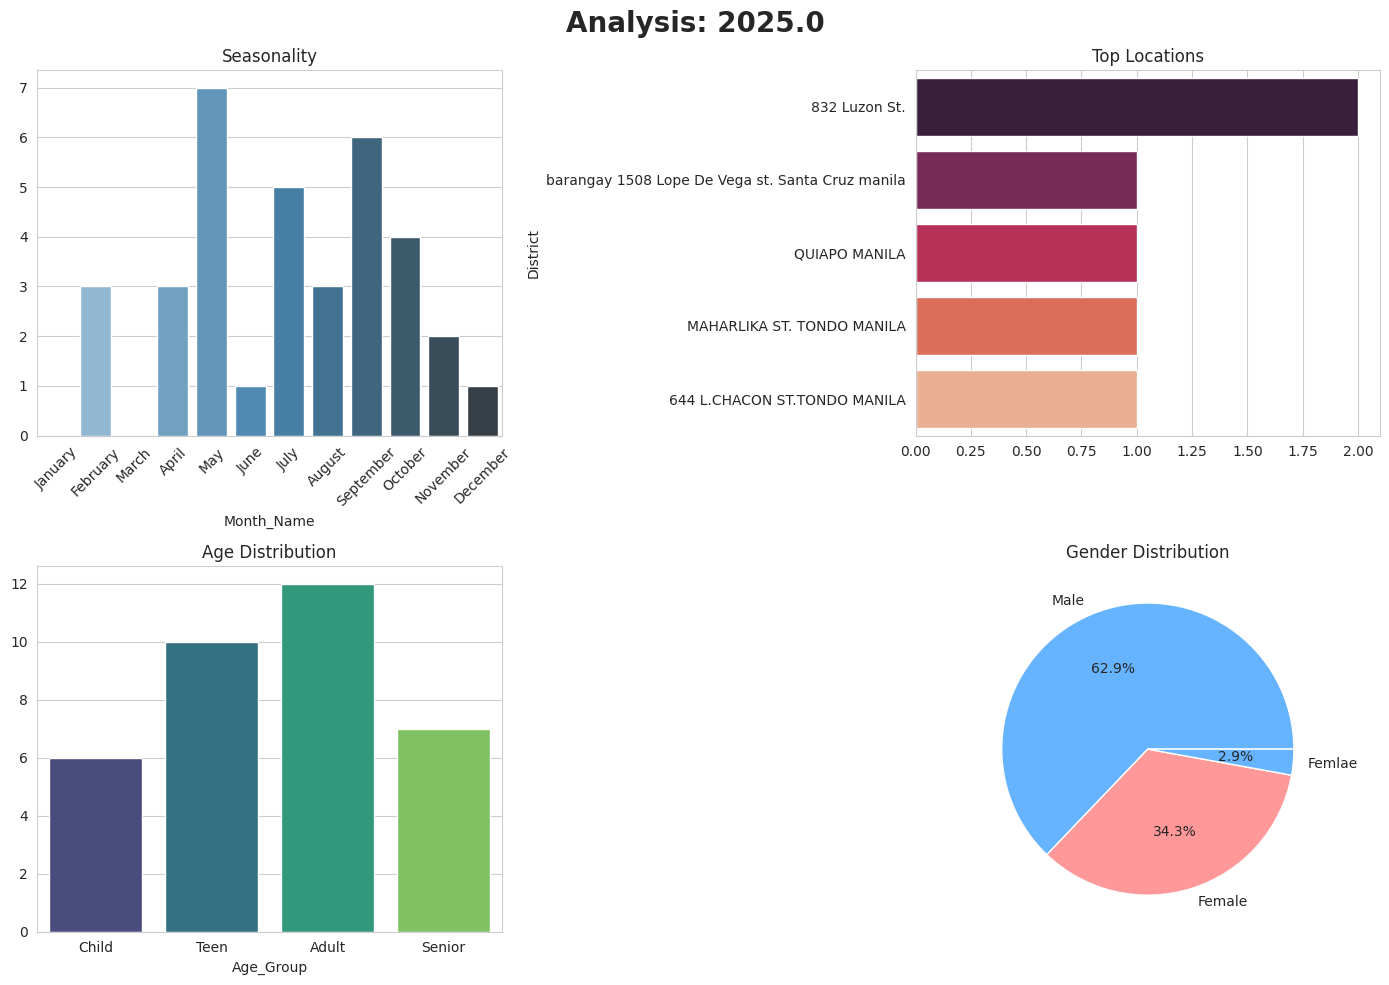

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Clean Data
df_clean = pd.read_csv('/content/DMResearch - Missing People.csv')

# Parse Dates
def parse_date_robust(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=False)
    except:
        try:
            return pd.to_datetime(date_str, dayfirst=True)
        except:
            return pd.NaT

df['Date_Cleaned'] = pd.to_datetime(df['Date Reported Missing'].apply(parse_date_robust))
df['Year'] = df['Date_Cleaned'].dt.year
df['Month_Name'] = df['Date_Cleaned'].dt.month_name()
df['Month'] = df['Date_Cleaned'].dt.month

# Clean Demographics & Location
df['GENDER'] = df['GENDER'].str.strip().str.title()
df['District'] = df['Location Last Seen'].astype(str).apply(lambda x: x.split(',')[0].strip())

def clean_age_group(age):
    str_val = str(age).lower().strip()
    if 'teen' in str_val: return 'Teen'
    if 'senior' in str_val: return 'Senior'
    if 'adult' in str_val: return 'Adult'
    if 'child' in str_val: return 'Child'
    if str_val.isdigit():
        val = int(str_val)
        if val < 13: return 'Child'
        elif val < 20: return 'Teen'
        elif val < 60: return 'Adult'
        else: return 'Senior'
    return 'Unknown'
df['Age_Group'] = df['AGE'].apply(clean_age_group)

# Filter 2020-2025
df = df[(df['Year'] >= 2020) & (df['Year'] <= 2025)]
sns.set_style("whitegrid")

# 2. Function: Overall Analysis (WITH Trend)
def plot_overall(data):
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle('Overall Analysis (2020-2025)', fontsize=20, weight='bold')
    gs = fig.add_gridspec(3, 2)

    # Trend
    ax1 = fig.add_subplot(gs[0, :])
    trend = data.groupby(data['Date_Cleaned'].dt.to_period('M')).size()
    trend.index = trend.index.astype(str)
    sns.lineplot(x=trend.index, y=trend.values, ax=ax1, marker='o', color='tab:blue')
    ax1.set_title('Overall Trend Over Time')
    ax1.set_xticks(range(0, len(trend), max(1, len(trend)//15)))
    ax1.tick_params(axis='x', rotation=45)

    # Seasonality
    ax2 = fig.add_subplot(gs[1, 0])
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    sns.countplot(x='Month_Name', data=data, order=month_order, ax=ax2, palette='Blues_d')
    ax2.set_title('Seasonality')
    ax2.tick_params(axis='x', rotation=45)

    # Top Locations
    ax3 = fig.add_subplot(gs[1, 1])
    top_locs = data['District'].value_counts().head(5)
    sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax3, palette='rocket')
    ax3.set_title('Top 5 Locations')

    # Age & Gender
    ax4 = fig.add_subplot(gs[2, 0])
    sns.countplot(x='Age_Group', data=data, order=['Child', 'Teen', 'Adult', 'Senior'], ax=ax4, palette='viridis')
    ax4.set_title('Age Distribution')

    ax5 = fig.add_subplot(gs[2, 1])
    data['GENDER'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax5, colors=['#66b3ff','#ff9999'])
    ax5.set_title('Gender Distribution')

    plt.tight_layout()
    plt.show()

# 3. Function: Yearly Analysis
def plot_yearly(data, year):
    if data.empty: return
    fig = plt.figure(figsize=(14, 10))
    fig.suptitle(f'Analysis: {year}', fontsize=20, weight='bold')
    gs = fig.add_gridspec(2, 2)

    # Seasonality
    ax1 = fig.add_subplot(gs[0, 0])
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    monthly_counts = data['Month_Name'].value_counts().reindex(month_order, fill_value=0)
    sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=ax1, palette='Blues_d')
    ax1.set_title('Seasonality')
    ax1.tick_params(axis='x', rotation=45)

    # Top Locations
    ax2 = fig.add_subplot(gs[0, 1])
    top_locs = data['District'].value_counts().head(5)
    if not top_locs.empty:
        sns.barplot(x=top_locs.values, y=top_locs.index, ax=ax2, palette='rocket')
    ax2.set_title('Top Locations')

    # Age & Gender
    ax3 = fig.add_subplot(gs[1, 0])
    age_counts = data['Age_Group'].value_counts().reindex(['Child', 'Teen', 'Adult', 'Senior'], fill_value=0)
    sns.barplot(x=age_counts.index, y=age_counts.values, ax=ax3, palette='viridis')
    ax3.set_title('Age Distribution')

    ax4 = fig.add_subplot(gs[1, 1])
    gender_counts = data['GENDER'].value_counts()
    if not gender_counts.empty:
        ax4.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
    ax4.set_title('Gender Distribution')

    plt.tight_layout()
    plt.show()

# Run
plot_overall(df)
for y in sorted(df['Year'].unique()):
    plot_yearly(df[df['Year'] == y], y)

/tmp/ipython-input-3223630991.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax2, palette='Blues_d')


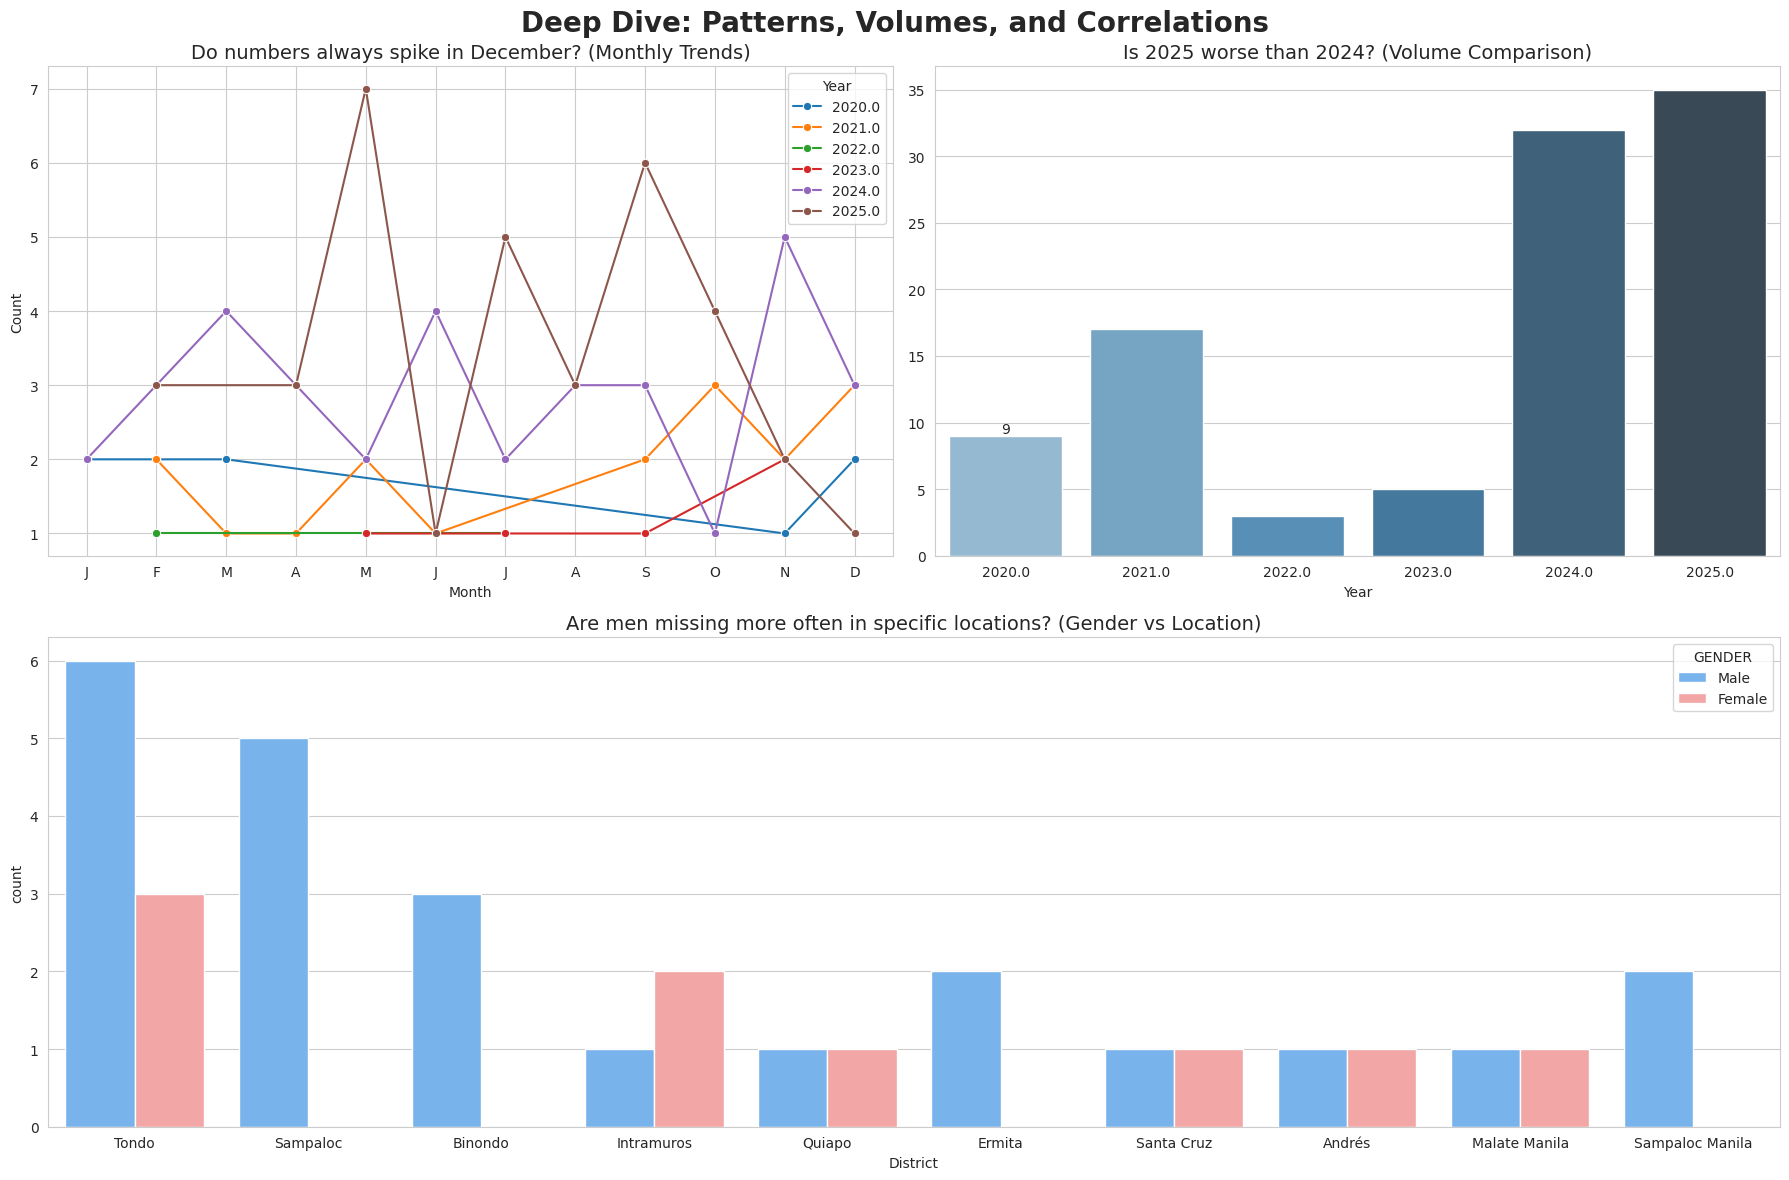

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Clean Data
df = pd.read_csv('/content/DMResearch - Missing People.csv')

# Parse Dates (Handling mixed formats)
def parse_date_robust(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=False)
    except:
        try:
            return pd.to_datetime(date_str, dayfirst=True)
        except:
            return pd.NaT

df['Date_Cleaned'] = pd.to_datetime(df['Date Reported Missing'].apply(parse_date_robust))
df['Year'] = df['Date_Cleaned'].dt.year
df['Month'] = df['Date_Cleaned'].dt.month
df['GENDER'] = df['GENDER'].str.strip().str.title()
df['District'] = df['Location Last Seen'].astype(str).apply(lambda x: x.split(',')[0].strip())

# Filter 2020-2025
df = df[(df['Year'] >= 2020) & (df['Year'] <= 2025)]

# 2. Generate Comparison Charts
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Deep Dive: Patterns, Volumes, and Correlations', fontsize=20, weight='bold')
gs = fig.add_gridspec(2, 2)

# Chart 1: Seasonality Patterns (Line Plot)
ax1 = fig.add_subplot(gs[0, 0])
monthly_data = df.groupby(['Year', 'Month']).size().reset_index(name='Count')
sns.lineplot(data=monthly_data, x='Month', y='Count', hue='Year', palette='tab10', marker='o', ax=ax1)
ax1.set_title('Do numbers always spike in December? (Monthly Trends)', fontsize=14)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax1.grid(True)

# Chart 2: Volume Comparison (Bar Plot)
ax2 = fig.add_subplot(gs[0, 1])
yearly_counts = df['Year'].value_counts().sort_index()
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, ax=ax2, palette='Blues_d')
ax2.set_title('Is 2025 worse than 2024? (Volume Comparison)', fontsize=14)
ax2.bar_label(ax2.containers[0])

# Chart 3: Correlation Gender vs Location (Grouped Bar)
ax3 = fig.add_subplot(gs[1, :])
top_locs = df['District'].value_counts().head(10).index
loc_gender_data = df[df['District'].isin(top_locs)]
sns.countplot(data=loc_gender_data, x='District', hue='GENDER', order=top_locs, ax=ax3, palette={'Male': '#66b3ff', 'Female': '#ff9999'})
ax3.set_title('Are men missing more often in specific locations? (Gender vs Location)', fontsize=14)

plt.tight_layout()
plt.show()